# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env allows the learner to hold a position as a percentage



In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, math, pickle
import numpy as np
import pandas as pd
import gymnasium as gym
import statsmodels.api as sm

from gymnasium import spaces
from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics

# Find parameters in `params.py`
from params import *
from envs.env_rl_freeop import PairTradingEnv

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-freeop-thres"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 257345


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do an experiment run with randomly generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0, verbose=1, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('compare_clos_thre': Discrete(3), 'compare_open_thre': Discrete(3), 'position': Box(-1.0, 1.0, (1,), float64), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(3)
action_space.sample: 0
networth 10089.256198347108, action 0, kc 1, pos -1.0, holding0 -864.2295393656555, holding1 787.0916961826053
networth 10089.083352439235, action 1, kc 1, pos 1.0, holding0 864.0801866413203, holding1 787.0916961826053
networth 9999.984572431364, action 2, kc 1, pos 1.0, holding0 864.0801866413203, holding1 0.0
networth 10089.083352439235, action 0, kc 1, pos 0, holding0 0.0, holding1 787.0916961826053
networth 10089.083352439235, action 1, kc 1, pos 0, holding0 0.0, holding1 787.0916961826053
networth 9999.040062395945, action 2, kc 1, pos 1.0, holding0 864.9770781074302, holding1 0.0
networth 9909.140038779477, action 2, kc 1, pos 1.0, holding0 864.9770781074302, holding1 -787.2156183578683
networth 9909.140038779477, action 1, kc 1, pos 1.0, holding0 864.977078

## Models from stable_baselines3

Train with training data

In [6]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log="logs")
model_ppo.learn(total_timesteps=500000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [7]:
'''A2C'''

env = PairTradingEnv(train0, train1, tc=0, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0)
model_a2c.learn(total_timesteps=500000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [8]:
'''DQN'''

env = PairTradingEnv(train0, train1, tc=0, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0)
model_dqn.learn(total_timesteps=500000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [9]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading.zip")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading.zip")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading.zip")

In [10]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
    print("existing networth_ppo.csv removed")
except OSError:
    print("currently no ppo results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

existing networth_ppo.csv removed
Test Finished!


In [11]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
    print("existing networth_a2c.csv removed")
except OSError:
    print("currently no a2c results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

existing networth_a2c.csv removed
Test Finished!


In [12]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
    print("existing networth_dqn.csv removed")
except OSError:
    print("currently no dqn results")

env = PairTradingEnv(test0, test1, tc=0, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

existing networth_dqn.csv removed
Test Finished!


### Analyze with Quanstats

In [13]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-10-31 23:59:59.999000', '9777.402112737229']
The ending capital of networth_dqn.csv is ['2023-10-31 23:59:59.999000', '9833.934753421461']
The ending capital of networth_ppo.csv is ['2023-10-31 23:59:59.999000', '9782.364693051437']
The best model is networth_dqn.csv


In [14]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Yearly return: -1%
Total orders count: 86232
Total long action: 53946
Total short action: 31726
Won orders count: 53946
Lost orders count: 31726
Win/Loss order ratio: 1.70037193469079
Avg order pnl: 0.0001403549334509288
Avg order pnl won: 0.012557562694052272
Avg order pnl lost: -0.02097103922561947
Avg long order pnl: -0.008256572868783618
Avg short order pnl: 0.00030440074705136215


                    Strategy
------------------  ----------
Start Period        2023-01-05
End Period          2023-10-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -2.81%
CAGR﹪              -2.37%

Sharpe              0.13
Prob. Sharpe Ratio  99.3%
Sortino             0.17
Sortino/√2          0.12
Omega               1.02

Max Drawdown        -4.5%
Longest DD Days     296

Gain/Pain Ratio     1742.96
Gain/Pain (1M)      -

Payoff Ratio        0.6
Profit Factor       1.02
Common Sense Ratio  0.53
CPC Index           0.38
Tail Ratio          0.53
Outlier Win Ratio   1.19
Outlier Loss Ratio  1.37

MTD                 0.06%
3M                  -0.99%
6M                  0.72%
YTD                 -2.81%
1Y                  -2.81%
3Y (ann.)           -2.37%
5Y (ann.)           -2.37%
10Y (ann.)          -2.37%
All-time (ann.)     -2.37%

Avg. Drawdown       -2.33%
Avg. Drawdown Days  15
Recovery Factor     269.2
Ulcer Index         0.03
Serenity Index      181.

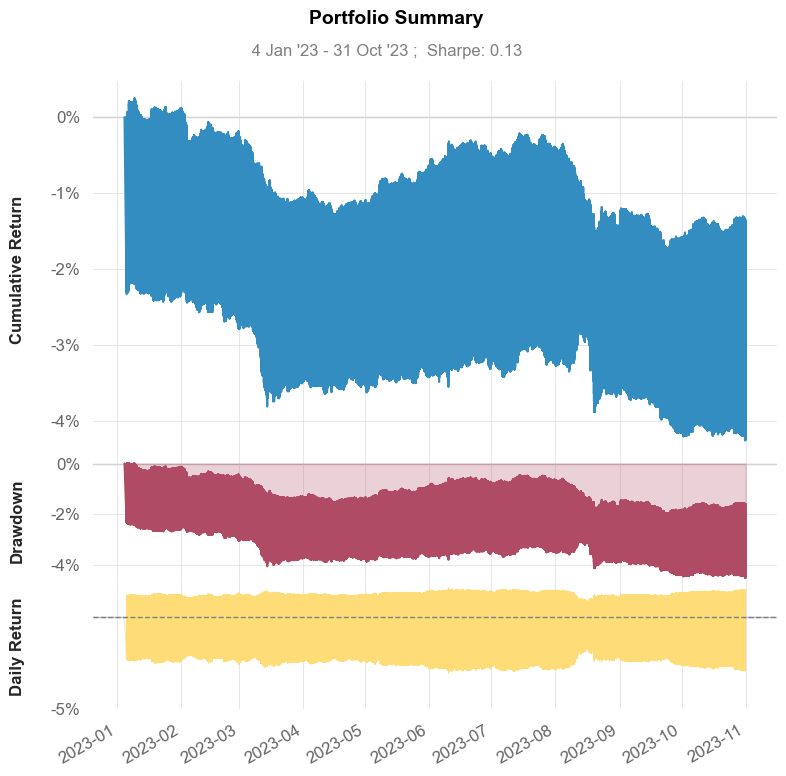

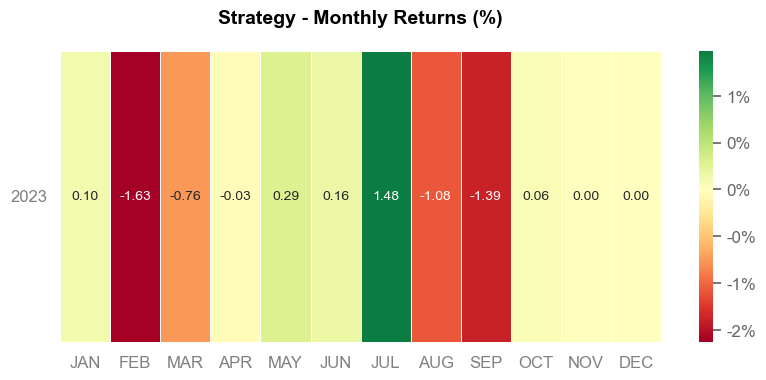

In [15]:
# best_return_daily = best_return['returns'].resample('1d').apply(lambda x: np.prod(1 + x) - 1)
qs.reports.basic(best_return['returns'])

In [16]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# ax1.plot(best_return.index, best_return['returns'], linewidth=0.5)
# ax1.set_title("Portfolio Returns")

# ax2.plot(best_return.index, best_return['values'], linewidth=0.5)
# ax2.set_title("Portfolio Networth")

# ax2.set_xticklabels(ax2.get_xticks(), rotation=45)
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))